# Analyze 6 models for 5 datasets
## Make a variety of plots, analyze each type of model
### Document the findings

In [159]:
import json
import csv
import os
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def read_log(file_path):
    with open(file_path, 'r') as file:
        return file.readlines()

def read_text(file_path):
    with open(file_path, 'r') as file:
        return file.read()

def read_csv(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        return [row for row in reader]

def parse_files(base_dir, model, study, size):
    directory = os.path.join(base_dir, f"{model}", study, size.upper())
    files = {
        "best": glob.glob(os.path.join(directory, "best-*.json")),
        "log": glob.glob(os.path.join(directory, "deap-*.log")),
        "fitnesses": glob.glob(os.path.join(directory, "fitnesses-*.txt")),
        "fitness": glob.glob(os.path.join(directory, "fitness-*.txt")),
        "hyperparams": glob.glob(os.path.join(directory, "*param*.json")),
        "cfg": glob.glob(os.path.join(directory, "cfg-*.sh")),
        "hpo": [os.path.join(directory, "hpo.csv")]
    }
    print(files)
    data = {}
    
    data['best'] = [read_json(file) for file in files['best']]
    data['log'] = [read_log(file) for file in files['log']]
    data['fitnesses'] = [read_text(file) for file in files['fitnesses']]
    data['fitness'] = [read_text(file) for file in files['fitness']]
    data['hyperparams'] = [read_json(file) for file in files['hyperparams']]
    data['cfg'] = [read_text(file) for file in files['cfg']]
    data['hpo'] = [read_csv(file) for file in files['hpo']]
    
    return data

def extract_values(hpo_data):
    header = hpo_data[0]  # First row is the header
    data = hpo_data[1:]  # Remaining rows are the data

    # Create a mapping of column names to their indices
    column_indices = {name: index for index, name in enumerate(header)}

    # Extract the necessary values using the column names
    iterations = []
    results = []
    learning_rates = []
    batch_sizes = []

    # LGBM does not have batch size
    
    # Define default values for columns
    default_values = {
        'iteration': '0',
        'sample': '0000',
        'result': '0.0',
        'learning_rate': '0.0',
        'batch_size': '0'
    }

    for row in data:
        print("model:", row )
        # Extract values using the column indices if they exist, otherwise use defaults
        iteration = row[column_indices['iteration']] if 'iteration' in column_indices else default_values['iteration']
        sample = row[column_indices['sample']] if 'sample' in column_indices else default_values['sample']
        result = row[column_indices['result']] if 'result' in column_indices else default_values['result']
        learning_rate = row[column_indices['learning_rate']] if 'learning_rate' in column_indices else default_values['learning_rate']
        batch_size = row[column_indices['batch_size']] if 'batch_size' in column_indices else default_values['batch_size']
    
        
        iterations.append(int(iteration))
        results.append(float(result))
        learning_rates.append(float(learning_rate))
        batch_sizes.append(int(batch_size))
    
    return iterations, results, learning_rates, batch_sizes

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_results(base_dir, models, studies, size="medium"):
    fig, axes = plt.subplots(len(models), len(studies), figsize=(18, 12), subplot_kw={'projection': '3d'})

    # Ensure axes is always 2D
    if len(models) == 1 and len(studies) == 1:
        axes = np.array([[axes]])
    elif len(models) == 1:
        axes = np.expand_dims(axes, axis=0)  # Add an extra dimension for single row
    elif len(studies) == 1:
        axes = np.expand_dims(axes, axis=1)  # Add an extra dimension for single column

    for i, model in enumerate(models):
        for j, study in enumerate(studies):
            print(f"--- Processing model: {model}, study: {study} ---")
            data = parse_files(base_dir, model, study, size)
            
            hpo_data = data['hpo'][0]
            iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
            
            # Find the indices of the best, second best, and third best results
            sorted_indices = sorted(range(len(results)), key=lambda k: results[k])
            min_index = sorted_indices[0]        
            min_result = results[min_index]
            min_lr = learning_rates[min_index]
            min_bs = batch_sizes[min_index]

            # Initialize second and third best indices to the first index
            second_best_index = min_index
            third_best_index = min_index

            # Find the second and third best distinct results
            for idx in sorted_indices[1:]:
                if results[idx] != min_result:
                    second_best_index = idx
                    break

            for idx in sorted_indices[1:]:
                if results[idx] != min_result and results[idx] != results[second_best_index]:
                    third_best_index = idx
                    break

            # If all results are the same, ensure we pick some other values
            if second_best_index == min_index:
                second_best_index = sorted_indices[1] if len(sorted_indices) > 1 else min_index
            if third_best_index == min_index:
                third_best_index = sorted_indices[2] if len(sorted_indices) > 2 else (sorted_indices[1] if len(sorted_indices) > 1 else min_index)

            second_best_result = results[second_best_index]
            second_best_lr = learning_rates[second_best_index]
            second_best_bs = batch_sizes[second_best_index]

            third_best_result = results[third_best_index]
            third_best_lr = learning_rates[third_best_index]
            third_best_bs = batch_sizes[third_best_index]

            ax = axes[i, j]
            scatter = ax.scatter(learning_rates, batch_sizes, results, c=results, cmap='viridis')
            ax.scatter(min_lr, min_bs, min_result, color='r', s=200, label=f'Best val_loss: ${min_result:.7e}$\nLR: ${min_lr:.7e}$, BS: {int(min_bs)}')
            ax.scatter(second_best_lr, second_best_bs, second_best_result, color='g', s=200, label=f'2nd Best: ${second_best_result:.7e}$\nLR: ${second_best_lr:.7e}$, BS: {int(second_best_bs)}')
            ax.scatter(third_best_lr, third_best_bs, third_best_result, color='b', s=200, label=f'3rd Best: ${third_best_result:.7e}$\nLR: ${third_best_lr:.7e}$, BS: {int(third_best_bs)}')
            
            ax.set_xlabel('Learning Rate')
            ax.set_ylabel('Batch Size')
            ax.set_zlabel('Val Loss')
            ax.set_title(f'{model} - {study}')
            ax.legend()
            cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, label='Validation Loss')
            cbar.ax.yaxis.label.set_size(10)  # Adjust color bar label size

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


# GraphDRP analysis 

## GraphDRP populate all large runs

--- Processing model: GraphDRP, study: gCSI ---
{'best': ['./GraphDRP/gCSI/LARGE/best-98.json'], 'log': ['./GraphDRP/gCSI/LARGE/deap-98.log'], 'fitnesses': ['./GraphDRP/gCSI/LARGE/fitnesses-98.txt'], 'fitness': ['./GraphDRP/gCSI/LARGE/fitness-98.txt'], 'hyperparams': ['./GraphDRP/gCSI/LARGE/graphdrp_param_space-3.json'], 'cfg': [], 'hpo': ['./GraphDRP/gCSI/LARGE/hpo.csv']}
model: ['003', '0017', '256', '0.038142533921189534', 'val_loss', '0.1154632419347763', '9']
model: ['003', '0018', '32', '0.013490422704852232', 'val_loss', '0.1154632419347763', '21']
model: ['003', '0018', '32', '0.013490422704852232', 'val_loss', '0.1154632419347763', '21']
model: ['004', '0005', '1024', '0.03676566535206966', 'val_loss', '0.1154632419347763', '6']
model: ['004', '0005', '1024', '0.03676566535206966', 'val_loss', '0.1154632419347763', '6']
model: ['004', '0005', '1024', '0.03676566535206966', 'val_loss', '0.1154632419347763', '6']
model: ['004', '0005', '1024', '0.03676566535206966', 'val_loss', 

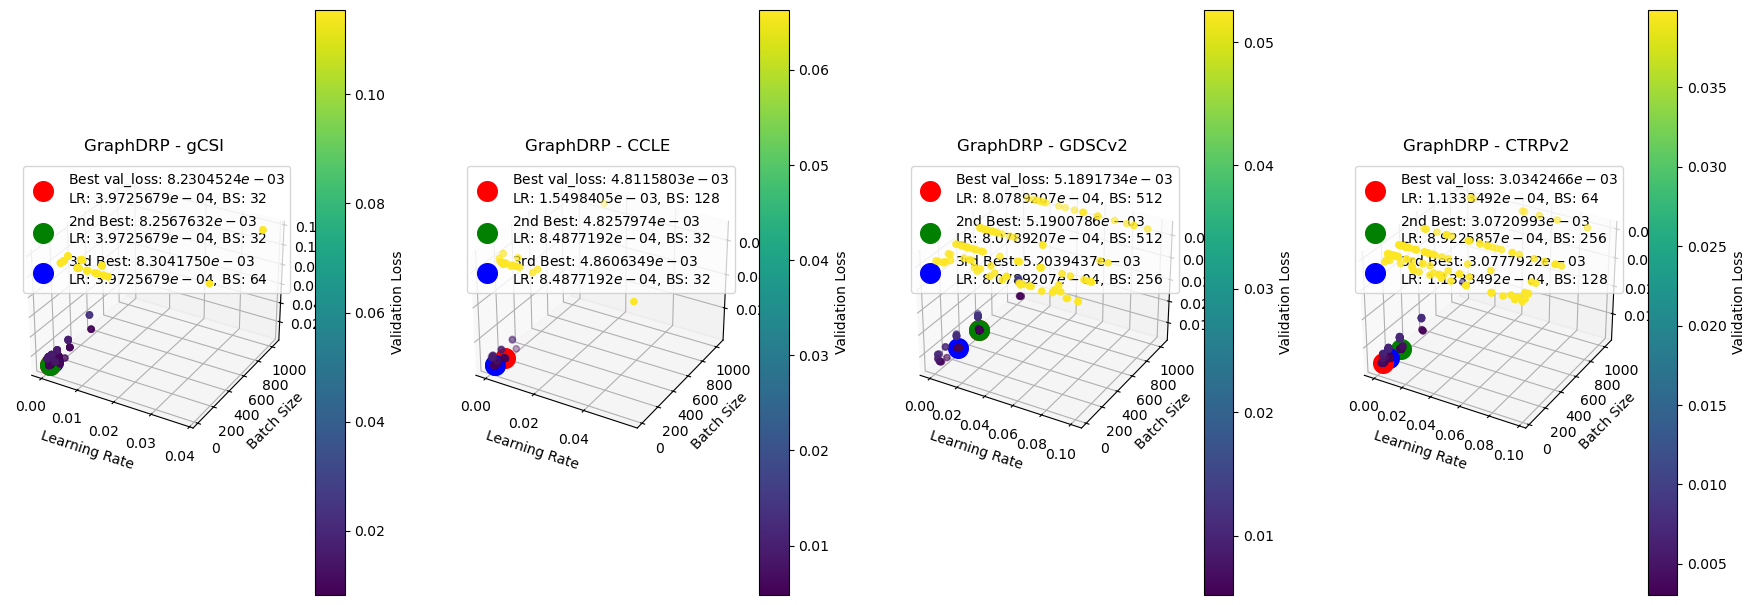

In [160]:
# Example usage
base_dir = "."
models = ["GraphDRP"]
studies = ["gCSI", "CCLE", "GDSCv2", "CTRPv2"] # GDSCv1 not available
plot_3d_results(base_dir, models, studies, "large")

# GraphDRP Medium Runs

--- Processing model: GraphDRP, study: gCSI ---
{'best': ['./GraphDRP/gCSI/MEDIUM/best-1.json'], 'log': ['./GraphDRP/gCSI/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/gCSI/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/gCSI/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/gCSI/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/gCSI/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/gCSI/MEDIUM/hpo.csv']}
model: ['001', '0000', '512', '0.021638577804816848', 'val_loss', '0.1154632419347763', '38']
model: ['001', '0001', '32', '0.03533235561246276', 'val_loss', '0.1154632419347763', '81']
model: ['001', '0002', '16', '0.054105244020367184', 'val_loss', '0.5533385276794434', '110']
model: ['001', '0003', '32', '0.00015145175483629418', 'val_loss', '0.009395802393555641', '182']
model: ['001', '0004', '32', '0.06981651588852394', 'val_loss', '0.1154632419347763', '78']
model: ['001', '0005', '64', '0.042399297488675346', 'val_loss', '0.1154632419347763', '57']
model: ['001', '0006'

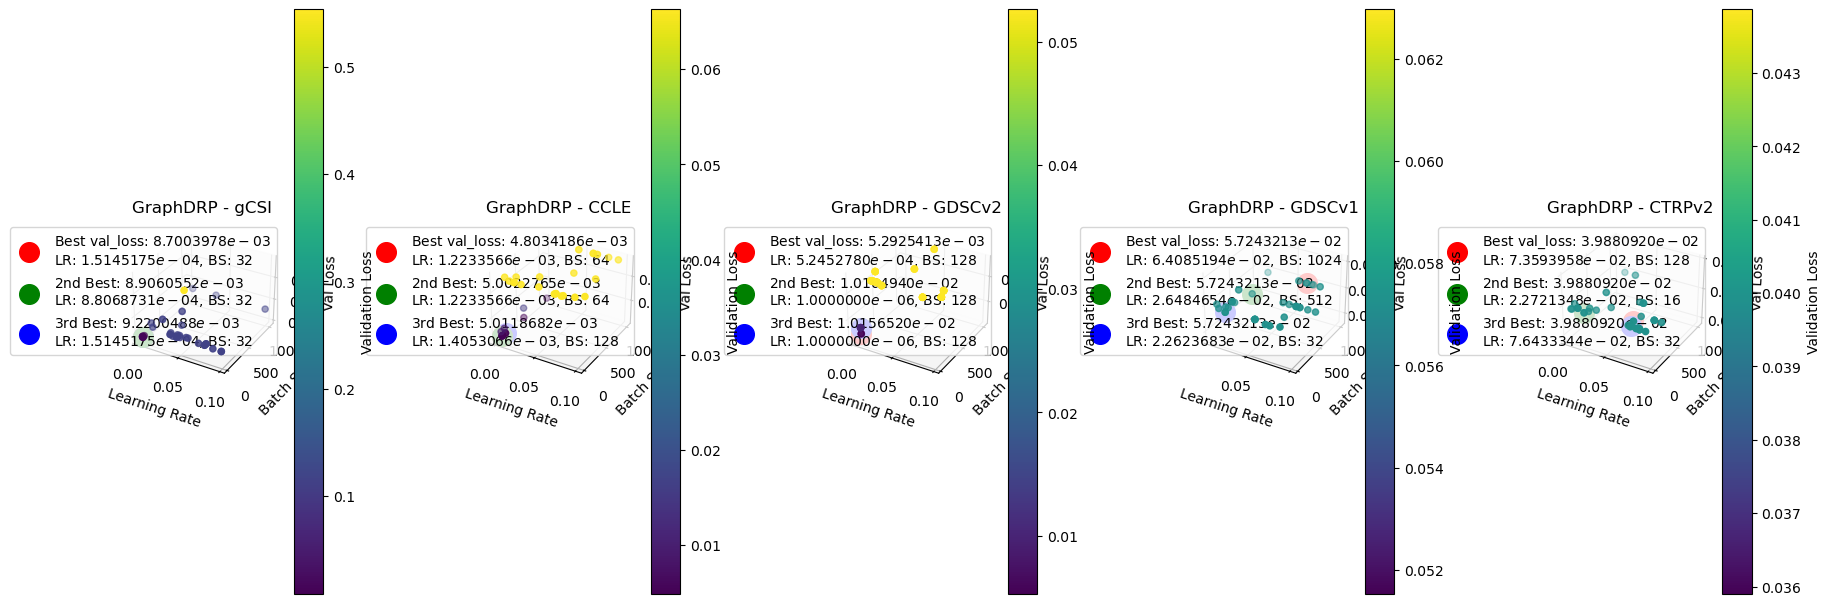

In [161]:
# Example usage
base_dir = "."
models = ["GraphDRP"]
studies = ["gCSI", "CCLE", "GDSCv2", "GDSCv1", "CTRPv2"]
plot_3d_results(base_dir, models, studies, "medium")

# From the large and medium runs we can see that Hyperparameters are indeed different for different datasets, but, both medium and large runs almost give the same minimum optimal result and learning rate and batch size combination 
model, val_loss, learning_rate, batch_size
See below:


In [190]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def process_and_plot_model_results(base_dir, models, studies, size="medium"):
    # Create a DataFrame to store the results
    results_df = pd.DataFrame(columns=['model', 'study', 'val_loss', 'learning_rate', 'batch_size'])

    for model in models:
        for study in studies:
            print(f"--- Processing model: {model}, study: {study} ---")
            data = parse_files(base_dir, model, study, size)
            
            hpo_data = data['hpo'][0]
            iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
            
            # Find the indices of the best, second best, and third best results
            sorted_indices = sorted(range(len(results)), key=lambda k: results[k])
            min_index = sorted_indices[0]        
            min_result = results[min_index]
            min_lr = learning_rates[min_index]
            min_bs = batch_sizes[min_index]

            # Initialize second and third best indices to the first index
            second_best_index = min_index
            third_best_index = min_index

            # Find the second and third best distinct results
            for idx in sorted_indices[1:]:
                if results[idx] != min_result:
                    second_best_index = idx
                    break

            for idx in sorted_indices[1:]:
                if results[idx] != min_result and results[idx] != results[second_best_index]:
                    third_best_index = idx
                    break

            # If all results are the same, ensure we pick some other values
            if second_best_index == min_index:
                second_best_index = sorted_indices[1] if len(sorted_indices) > 1 else min_index
            if third_best_index == min_index:
                third_best_index = sorted_indices[2] if len(sorted_indices) > 2 else (sorted_indices[1] if len(sorted_indices) > 1 else min_index)

            second_best_result = results[second_best_index]
            second_best_lr = learning_rates[second_best_index]
            second_best_bs = batch_sizes[second_best_index]

            third_best_result = results[third_best_index]
            third_best_lr = learning_rates[third_best_index]
            third_best_bs = batch_sizes[third_best_index]

            # Append the best results to the DataFrame
            new_rows = pd.DataFrame([
                {'model': model, 'study': study, 'val_loss': min_result, 'learning_rate': min_lr, 'batch_size': int(min_bs)}
            ])
            results_df = pd.concat([results_df, new_rows], ignore_index=True)

    # Print the results DataFrame
    print(results_df)

    # Plotting the 3D plot for all models
    fig = plt.figure(figsize=(18, 12))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each point
    for i, row in results_df.iterrows():
        ax.scatter(row['learning_rate'], row['batch_size'], row['val_loss'], label=f"{row['model']} {row['study']}", s=200)

    # Set labels
    ax.set_xlabel('Learning Rate', fontsize=24)
    ax.set_ylabel('Batch Size', fontsize=20)
    ax.set_zlabel('Validation Loss', fontsize=20)
    ax.set_title('3D Plot for GraphDRP and IGTD (all 5 datasets) of Validation Loss vs Learning Rate and Batch Size', fontsize=24)

    # Adjust legend location
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=18)
    plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust the right margin to make space for the legend
    plt.show()


--- Processing model: GraphDRP, study: gCSI ---
{'best': ['./GraphDRP/gCSI/MEDIUM/best-1.json'], 'log': ['./GraphDRP/gCSI/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/gCSI/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/gCSI/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/gCSI/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/gCSI/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/gCSI/MEDIUM/hpo.csv']}
model: ['001', '0000', '512', '0.021638577804816848', 'val_loss', '0.1154632419347763', '38']
model: ['001', '0001', '32', '0.03533235561246276', 'val_loss', '0.1154632419347763', '81']
model: ['001', '0002', '16', '0.054105244020367184', 'val_loss', '0.5533385276794434', '110']
model: ['001', '0003', '32', '0.00015145175483629418', 'val_loss', '0.009395802393555641', '182']
model: ['001', '0004', '32', '0.06981651588852394', 'val_loss', '0.1154632419347763', '78']
model: ['001', '0005', '64', '0.042399297488675346', 'val_loss', '0.1154632419347763', '57']
model: ['001', '0006'

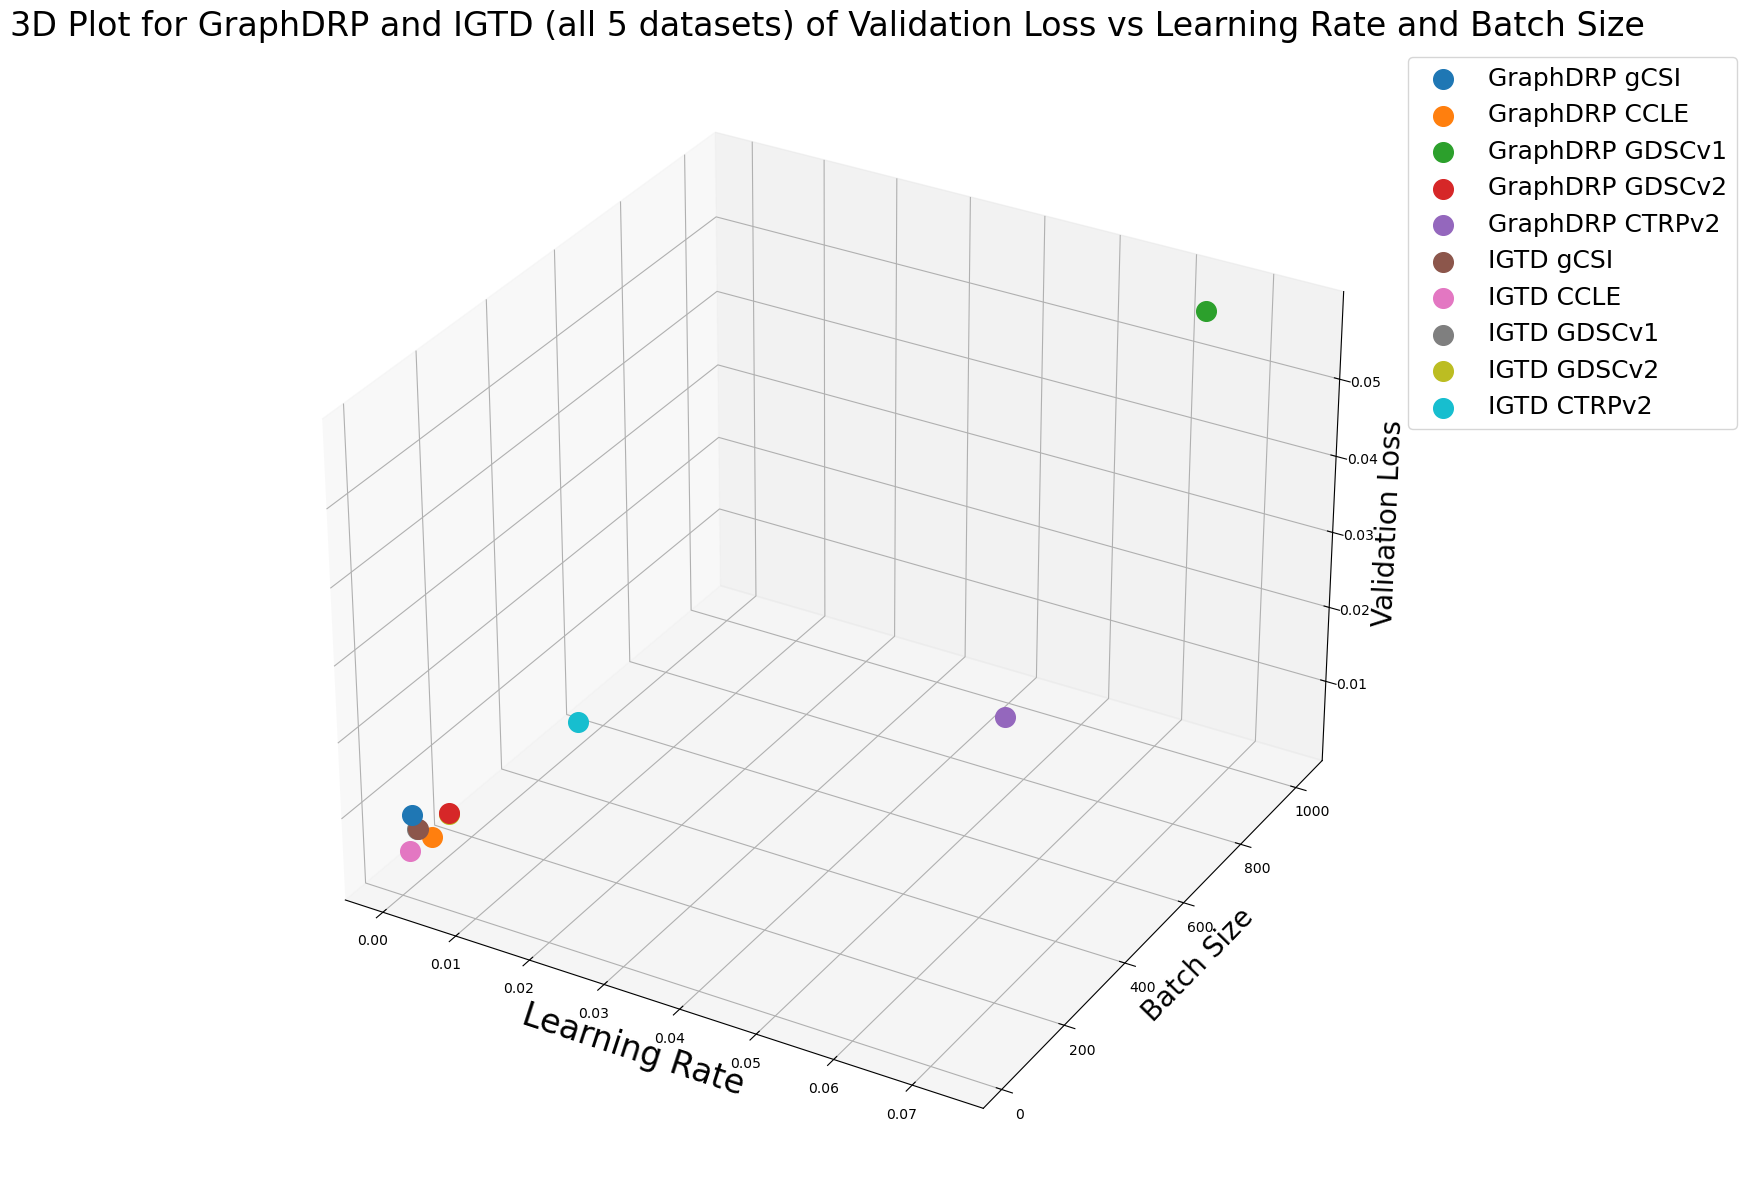

In [191]:

# Example usage
base_dir = "."
models = ["GraphDRP", "IGTD"]
studies = ["gCSI", "CCLE", "GDSCv1", "GDSCv2", "CTRPv2"]
process_and_plot_model_results(base_dir, models, studies)


--- Processing model: GraphDRP, study: gCSI ---
{'best': ['./GraphDRP/gCSI/MEDIUM/best-1.json'], 'log': ['./GraphDRP/gCSI/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/gCSI/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/gCSI/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/gCSI/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/gCSI/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/gCSI/MEDIUM/hpo.csv']}
model: ['001', '0000', '512', '0.021638577804816848', 'val_loss', '0.1154632419347763', '38']
model: ['001', '0001', '32', '0.03533235561246276', 'val_loss', '0.1154632419347763', '81']
model: ['001', '0002', '16', '0.054105244020367184', 'val_loss', '0.5533385276794434', '110']
model: ['001', '0003', '32', '0.00015145175483629418', 'val_loss', '0.009395802393555641', '182']
model: ['001', '0004', '32', '0.06981651588852394', 'val_loss', '0.1154632419347763', '78']
model: ['001', '0005', '64', '0.042399297488675346', 'val_loss', '0.1154632419347763', '57']
model: ['001', '0006'

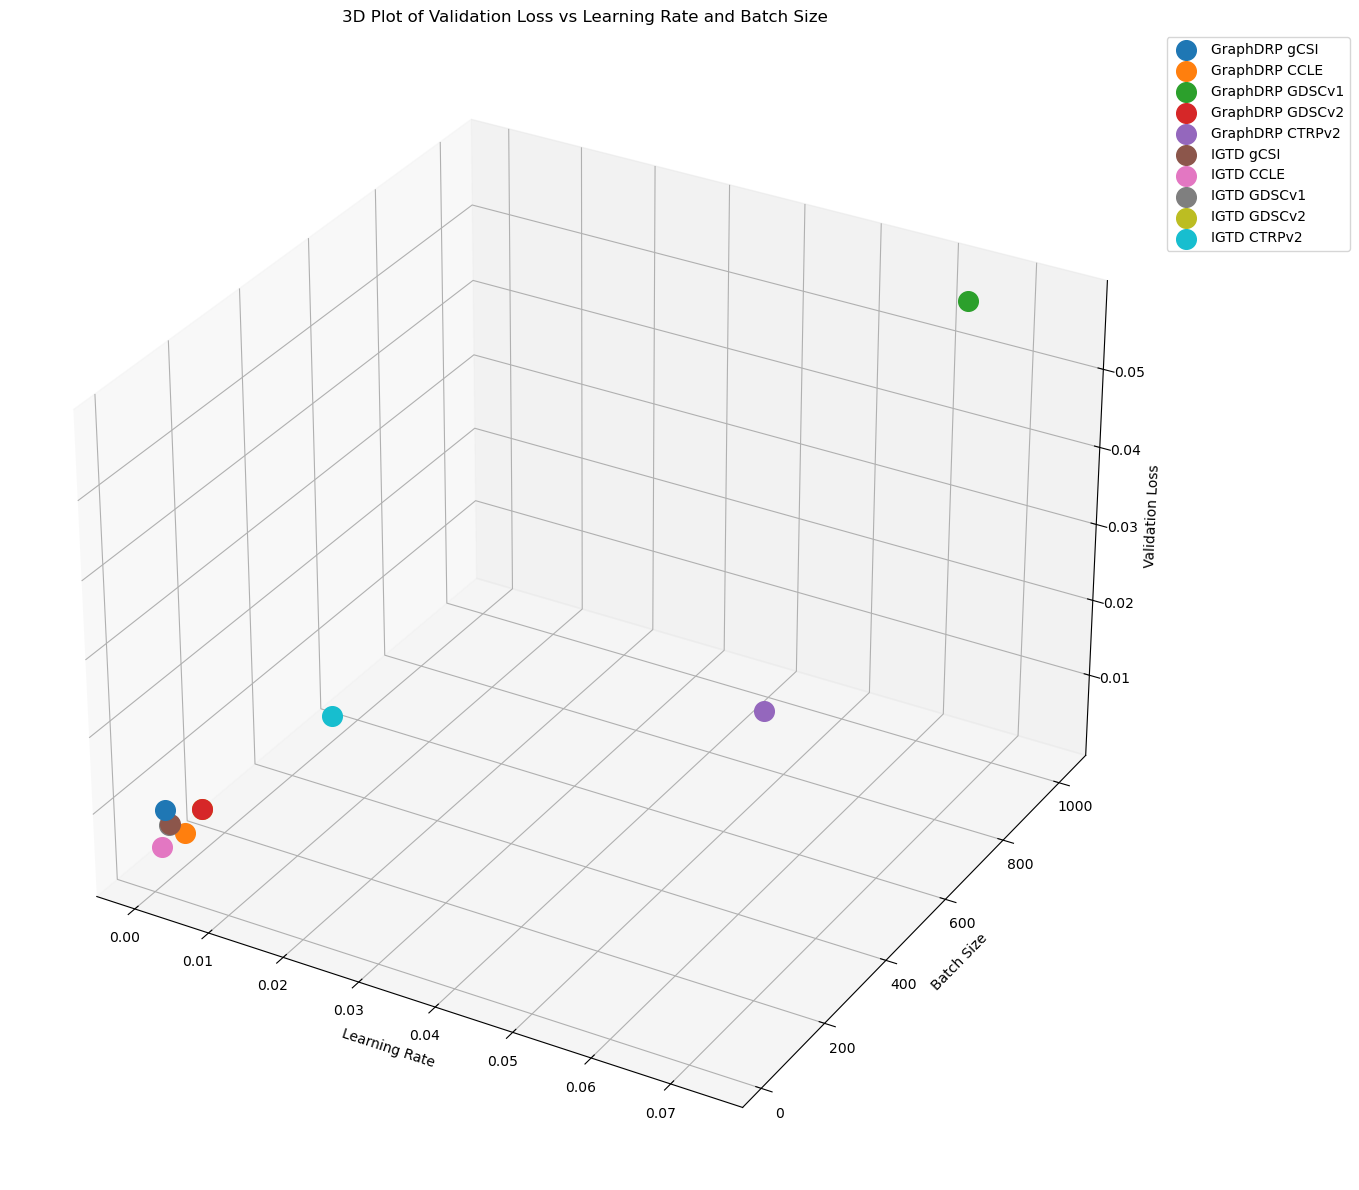

In [189]:

# Example usage
base_dir = "."
models = ["GraphDRP", "IGTD"]
studies = ["gCSI", "CCLE", "GDSCv1", "GDSCv2", "CTRPv2"]
process_and_plot_results(base_dir, models, studies)


# IGDT


--- Processing model: IGTD, study: gCSI ---
{'best': ['./IGTD/gCSI/MEDIUM/best-8.json'], 'log': ['./IGTD/gCSI/MEDIUM/deap-8.log'], 'fitnesses': ['./IGTD/gCSI/MEDIUM/fitnesses-8.txt'], 'fitness': ['./IGTD/gCSI/MEDIUM/fitness-8.txt'], 'hyperparams': ['./IGTD/gCSI/MEDIUM/hyperparams.IGTD.gCSI.medium.json'], 'cfg': [], 'hpo': ['./IGTD/gCSI/MEDIUM/hpo.csv']}
model: ['001', '0000', '16', '0.0003642314805203391', 'val_loss', '0.00813145333643479', '234']
model: ['001', '0001', '32', '0.00023616142305772018', 'val_loss', '0.007807533415941592', '191']
model: ['001', '0002', '1028', '0.0008038550722521798', 'val_loss', '0.025223417443236147', '38']
model: ['001', '0003', '32', '8.329028390235976e-05', 'val_loss', '0.010260167389059174', '192']
model: ['001', '0004', '32', '0.0008434053110179821', 'val_loss', '0.007097294089191427', '162']
model: ['001', '0005', '256', '0.00024226595938049716', 'val_loss', '0.0676055380222777', '34']
model: ['001', '0006', '16', '0.00029850191979512365', 'val_lo

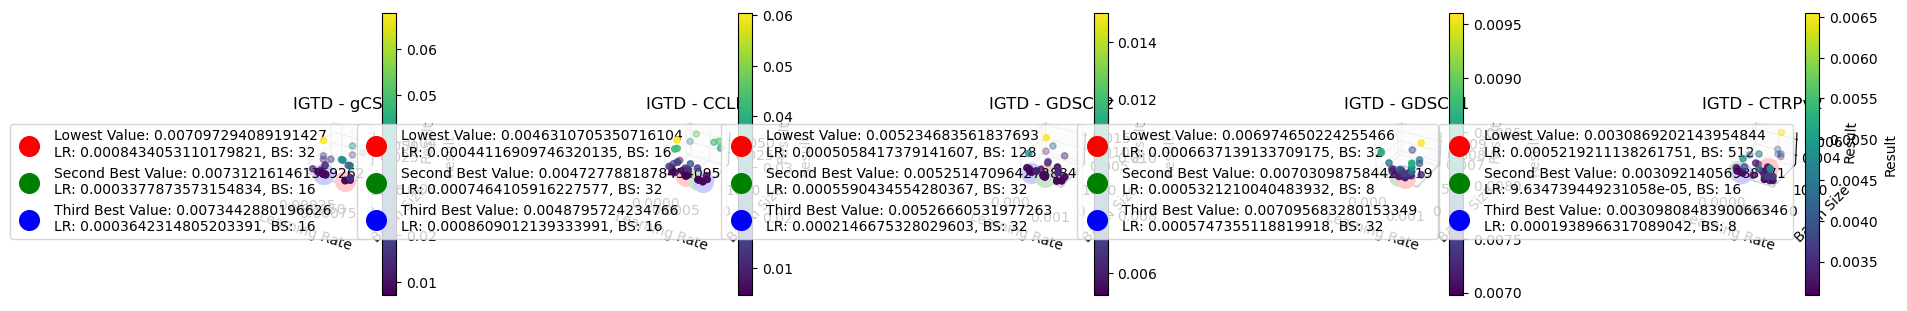

In [165]:

base_dir = "."
models = ["IGTD"]
# studies = ["gCSI", "GDSCv1", "CCLE", "GDSCv2"] gdscv1, CTRP not available! aug 6th 2024
studies = ["gCSI", "CCLE", "GDSCv2", "GDSCv1", "CTRPv2"]

size = "medium"

fig = plt.figure(figsize=(18, 12))
extra_min = 2

for i, model in enumerate(models):
    for j, study in enumerate(studies):
        print(f"--- Processing model: {model}, study: {study} ---")
        data = parse_files(base_dir, model, study, size)
        
        hpo_data = data['hpo'][0]
        iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
        
        # Find the indices of the best, second best, and third best results
        sorted_indices = sorted(range(len(results)), key=lambda k: results[k])
        min_index = sorted_indices[0]        
        min_result = results[min_index]
        min_lr = learning_rates[min_index]
        min_bs = batch_sizes[min_index]

        # Initialize second and third best indices to the first index
        second_best_index = min_index
        third_best_index = min_index

        # Find the second and third best distinct results
        for idx in sorted_indices[1:]:
            if results[idx] != min_result:
                second_best_index = idx
                break

        for idx in sorted_indices[1:]:
            if results[idx] != min_result and results[idx] != results[second_best_index]:
                third_best_index = idx
                break

        # If all results are the same, ensure we pick some other values
        if second_best_index == min_index:
            second_best_index = sorted_indices[1] if len(sorted_indices) > 1 else min_index
        if third_best_index == min_index:
            third_best_index = sorted_indices[2] if len(sorted_indices) > 2 else (sorted_indices[1] if len(sorted_indices) > 1 else min_index)

        second_best_result = results[second_best_index]
        second_best_lr = learning_rates[second_best_index]
        second_best_bs = batch_sizes[second_best_index]

        third_best_result = results[third_best_index]
        third_best_lr = learning_rates[third_best_index]
        third_best_bs = batch_sizes[third_best_index]

        
        ax = fig.add_subplot(len(models), len(studies), i * len(studies) + j + 1, projection='3d')
        scatter = ax.scatter(learning_rates, batch_sizes, results, c=results, cmap='viridis')
        ax.scatter(min_lr, min_bs, min_result, color='r', s=200, label=f'Lowest Value: {min_result} \nLR: {min_lr}, BS: {min_bs}')
        ax.scatter(second_best_lr, second_best_bs, second_best_result, color='g', s=200, label=f'Second Best Value: {second_best_result}\nLR: {second_best_lr}, BS: {second_best_bs}')
        ax.scatter(third_best_lr, third_best_bs, third_best_result, color='b', s=200, label=f'Third Best Value: {third_best_result}\nLR: {third_best_lr}, BS: {third_best_bs}')
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Batch Size')
        ax.set_zlabel('Result')
        ax.set_title(f'{model} - {study}')
        ax.legend()
        fig.colorbar(scatter, ax=ax, label='Result')

plt.tight_layout()
plt.show()


# IGTD large

--- Processing model: IGTD, study: gCSI ---
{'best': ['./IGTD/gCSI/LARGE/best-8.json'], 'log': ['./IGTD/gCSI/LARGE/deap-8.log'], 'fitnesses': ['./IGTD/gCSI/LARGE/fitnesses-8.txt'], 'fitness': ['./IGTD/gCSI/LARGE/fitness-8.txt'], 'hyperparams': ['./IGTD/gCSI/LARGE/hyperparams.IGTD.gCSI.large.json'], 'cfg': [], 'hpo': ['./IGTD/gCSI/LARGE/hpo.csv']}
model: ['001', '0000', '512', '0.00028758399527195063', 'val_loss', '0.03819999815756462', '37']
model: ['001', '0001', '16', '0.00031676082872397326', 'val_loss', '0.0079326672804813', '241']
model: ['001', '0002', '1028', '0.0009588058173404848', 'val_loss', '0.01488539658148113', '45']
model: ['001', '0003', '64', '0.00045506607268103394', 'val_loss', '0.009128995721732385', '118']
model: ['001', '0004', '32', '0.0008521670216196102', 'val_loss', '0.013778465376499818', '96']
model: ['001', '0005', '64', '0.000851074034525542', 'val_loss', '0.008219416253886013', '111']
model: ['001', '0006', '64', '0.00016339475653812284', 'val_loss', '0.0

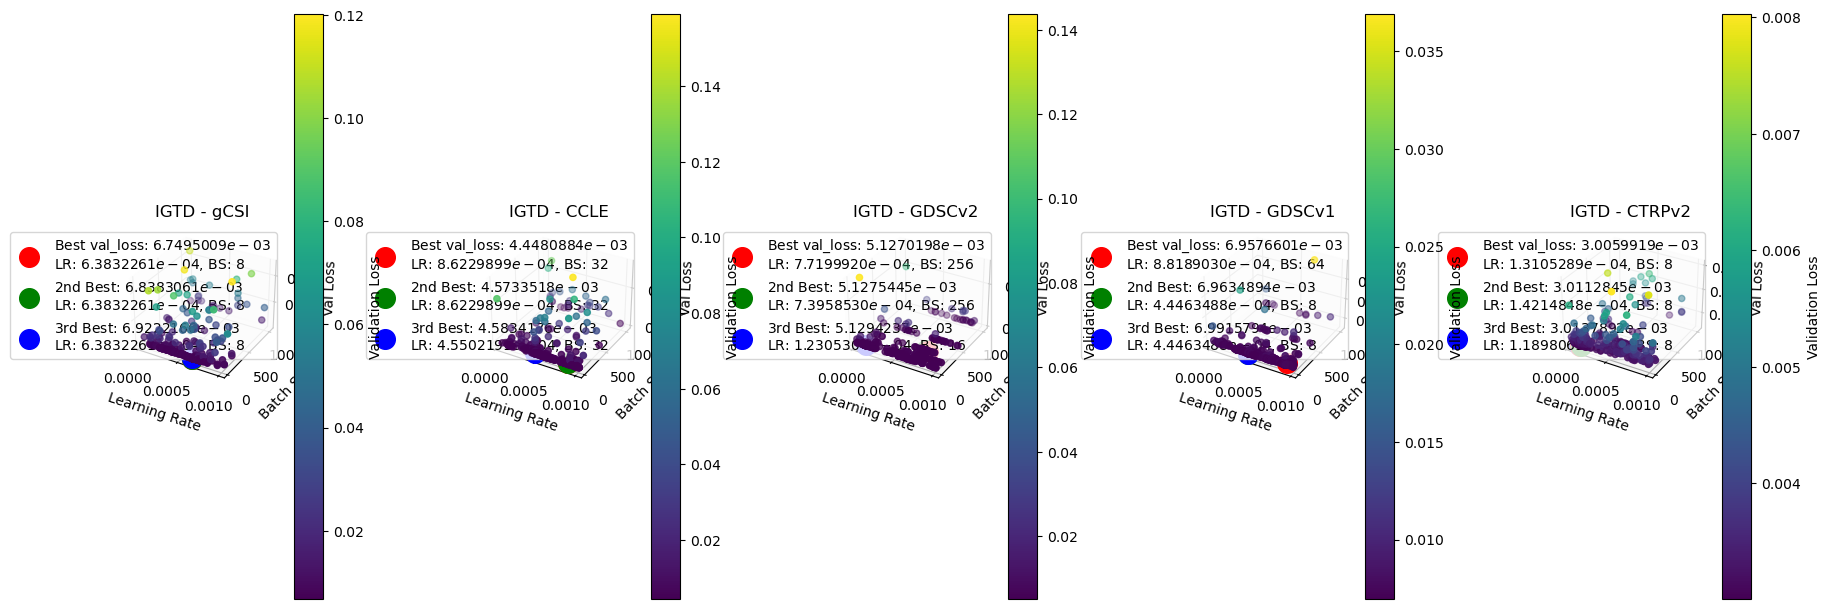

In [166]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_3d_results(base_dir, models, studies, size="large"):
    fig, axes = plt.subplots(len(models), len(studies), figsize=(18, 12), subplot_kw={'projection': '3d'})

    # Ensure axes is always 2D
    if len(models) == 1 and len(studies) == 1:
        axes = np.array([[axes]])
    elif len(models) == 1:
        axes = np.expand_dims(axes, axis=0)  # Add an extra dimension for single row
    elif len(studies) == 1:
        axes = np.expand_dims(axes, axis=1)  # Add an extra dimension for single column

    for i, model in enumerate(models):
        for j, study in enumerate(studies):
            print(f"--- Processing model: {model}, study: {study} ---")
            data = parse_files(base_dir, model, study, size)
            
            hpo_data = data['hpo'][0]
            iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
            
            # Find the indices of the best, second best, and third best results
            sorted_indices = sorted(range(len(results)), key=lambda k: results[k])
            min_index = sorted_indices[0]        
            min_result = results[min_index]
            min_lr = learning_rates[min_index]
            min_bs = batch_sizes[min_index]

            # Initialize second and third best indices to the first index
            second_best_index = min_index
            third_best_index = min_index

            # Find the second and third best distinct results
            for idx in sorted_indices[1:]:
                if results[idx] != min_result:
                    second_best_index = idx
                    break

            for idx in sorted_indices[1:]:
                if results[idx] != min_result and results[idx] != results[second_best_index]:
                    third_best_index = idx
                    break

            # If all results are the same, ensure we pick some other values
            if second_best_index == min_index:
                second_best_index = sorted_indices[1] if len(sorted_indices) > 1 else min_index
            if third_best_index == min_index:
                third_best_index = sorted_indices[2] if len(sorted_indices) > 2 else (sorted_indices[1] if len(sorted_indices) > 1 else min_index)

            second_best_result = results[second_best_index]
            second_best_lr = learning_rates[second_best_index]
            second_best_bs = batch_sizes[second_best_index]

            third_best_result = results[third_best_index]
            third_best_lr = learning_rates[third_best_index]
            third_best_bs = batch_sizes[third_best_index]

            ax = axes[i, j]
            scatter = ax.scatter(learning_rates, batch_sizes, results, c=results, cmap='viridis')
            ax.scatter(min_lr, min_bs, min_result, color='r', s=200, label=f'Best val_loss: ${min_result:.7e}$\nLR: ${min_lr:.7e}$, BS: {int(min_bs)}')
            ax.scatter(second_best_lr, second_best_bs, second_best_result, color='g', s=200, label=f'2nd Best: ${second_best_result:.7e}$\nLR: ${second_best_lr:.7e}$, BS: {int(second_best_bs)}')
            ax.scatter(third_best_lr, third_best_bs, third_best_result, color='b', s=200, label=f'3rd Best: ${third_best_result:.7e}$\nLR: ${third_best_lr:.7e}$, BS: {int(third_best_bs)}')
            
            ax.set_xlabel('Learning Rate')
            ax.set_ylabel('Batch Size')
            ax.set_zlabel('Val Loss')
            ax.set_title(f'{model} - {study}')
            ax.legend()
            cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, label='Validation Loss')
            cbar.ax.yaxis.label.set_size(10)  # Adjust color bar label size

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example usage
base_dir = "."
models = ["IGTD"]
studies = ["gCSI", "CCLE", "GDSCv2", "GDSCv1", "CTRPv2"]
plot_3d_results(base_dir, models, studies)


--- Processing model: IGTD, study: gCSI ---
{'best': ['./IGTD/gCSI/LARGE/best-8.json'], 'log': ['./IGTD/gCSI/LARGE/deap-8.log'], 'fitnesses': ['./IGTD/gCSI/LARGE/fitnesses-8.txt'], 'fitness': ['./IGTD/gCSI/LARGE/fitness-8.txt'], 'hyperparams': ['./IGTD/gCSI/LARGE/hyperparams.IGTD.gCSI.large.json'], 'cfg': [], 'hpo': ['./IGTD/gCSI/LARGE/hpo.csv']}
model: ['001', '0000', '512', '0.00028758399527195063', 'val_loss', '0.03819999815756462', '37']
model: ['001', '0001', '16', '0.00031676082872397326', 'val_loss', '0.0079326672804813', '241']
model: ['001', '0002', '1028', '0.0009588058173404848', 'val_loss', '0.01488539658148113', '45']
model: ['001', '0003', '64', '0.00045506607268103394', 'val_loss', '0.009128995721732385', '118']
model: ['001', '0004', '32', '0.0008521670216196102', 'val_loss', '0.013778465376499818', '96']
model: ['001', '0005', '64', '0.000851074034525542', 'val_loss', '0.008219416253886013', '111']
model: ['001', '0006', '64', '0.00016339475653812284', 'val_loss', '0.0

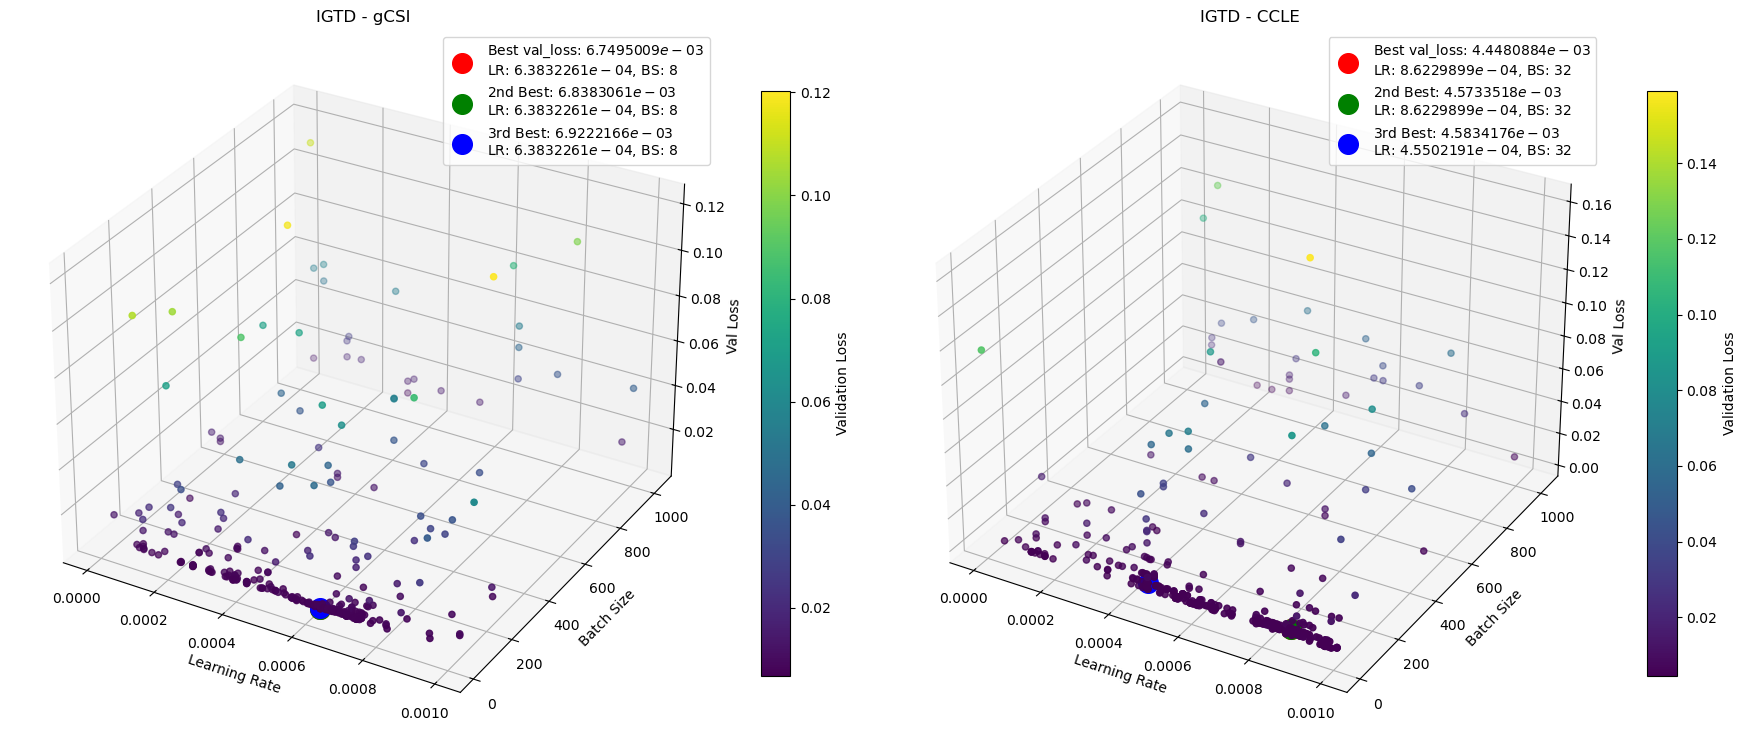

In [167]:
base_dir = "."
models = ["IGTD"]
studies = ["gCSI", "CCLE"]
plot_3d_results(base_dir, models, studies)


In [174]:
models = ["GraphDRP", "IGTD", "Paccmann_MCA", "PathDSP", "HiDRA", "LGBM"]
studies = ["gCSI", "CCLE"]
size = "medium"

# Plot learning rate and batch size variations for all models and datasets individually

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

--- Processing model: GraphDRP, study: gCSI ---
{'best': ['./GraphDRP/gCSI/MEDIUM/best-1.json'], 'log': ['./GraphDRP/gCSI/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/gCSI/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/gCSI/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/gCSI/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/gCSI/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/gCSI/MEDIUM/hpo.csv']}
model: ['001', '0000', '512', '0.021638577804816848', 'val_loss', '0.1154632419347763', '38']
model: ['001', '0001', '32', '0.03533235561246276', 'val_loss', '0.1154632419347763', '81']
model: ['001', '0002', '16', '0.054105244020367184', 'val_loss', '0.5533385276794434', '110']
model: ['001', '0003', '32', '0.00015145175483629418', 'val_loss', '0.009395802393555641', '182']
model: ['001', '0004', '32', '0.06981651588852394', 'val_loss', '0.1154632419347763', '78']
model: ['001', '0005', '64', '0.042399297488675346', 'val_loss', '0.1154632419347763', '57']
model: ['001', '0006'

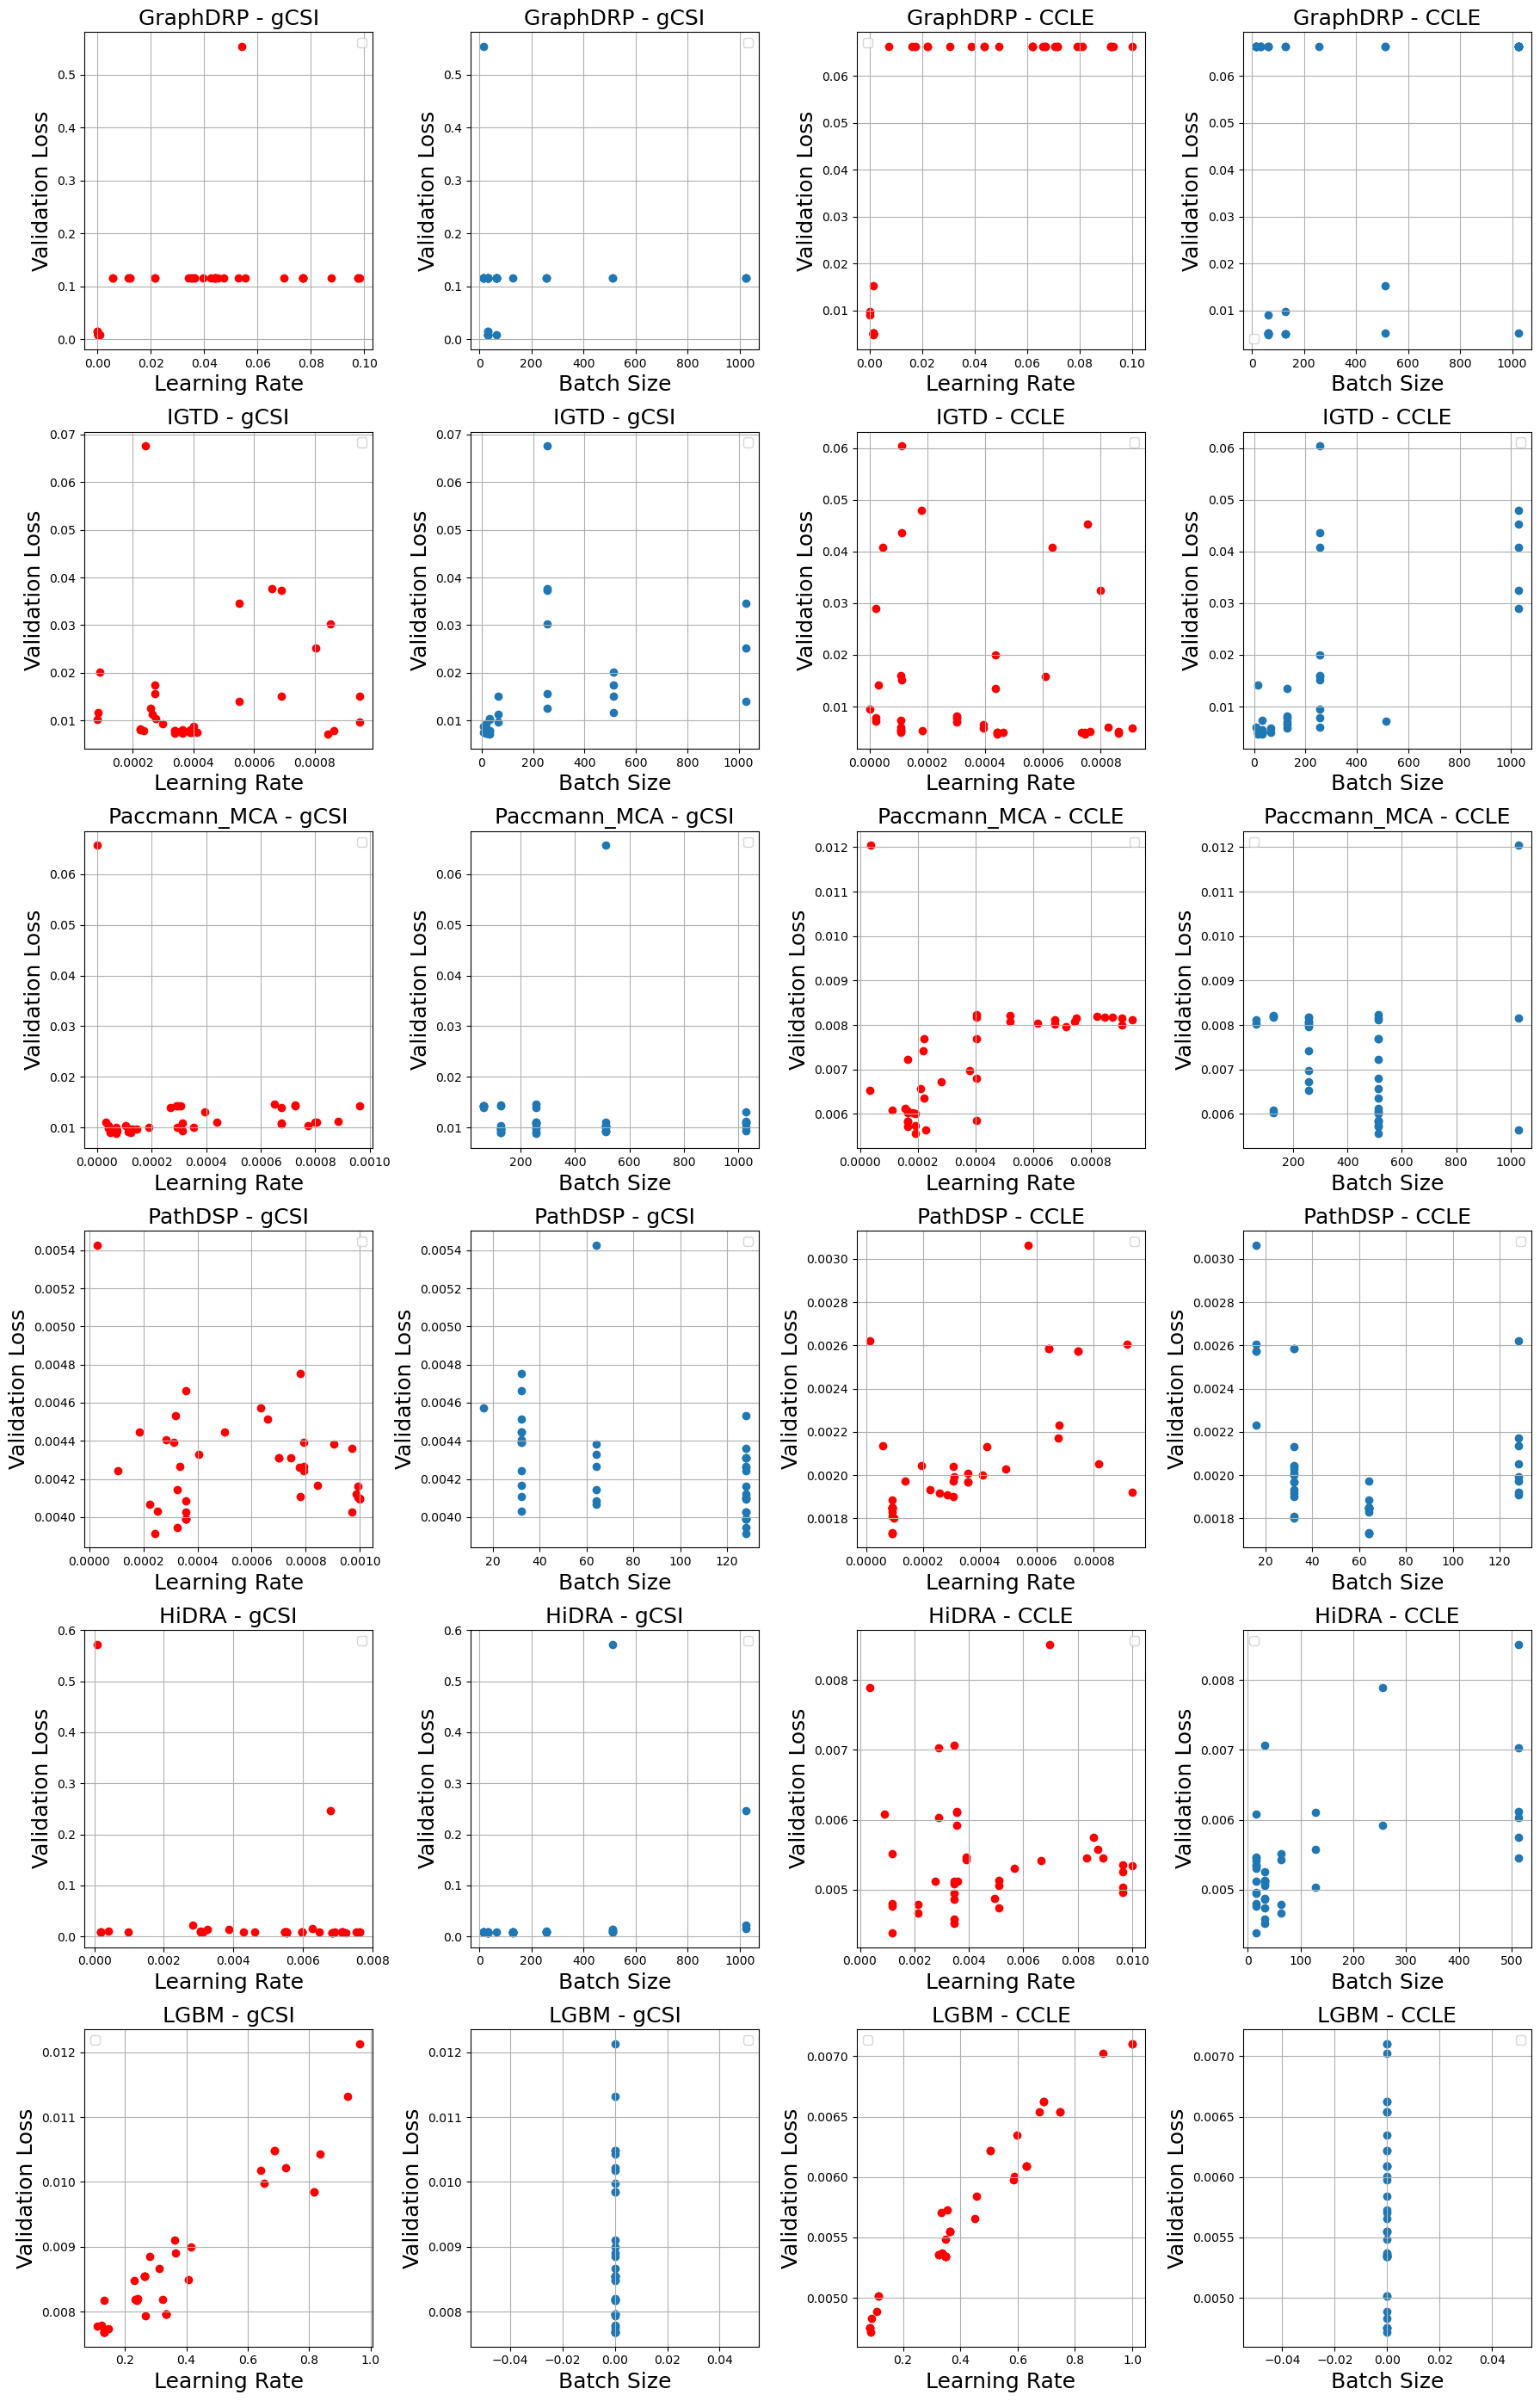

In [176]:
fig, axes = plt.subplots(len(models), len(studies) * 2, figsize=(18, 28))

for i, model in enumerate(models):
    for j, study in enumerate(studies):
        print(f"--- Processing model: {model}, study: {study} ---")
        data = parse_files(base_dir, model, study, size="medium")
        
        hpo_data = data['hpo'][0]
        iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
        print(learning_rates)
        
        label = f"{model} - {study}"
        
        # Plot Result vs Learning Rate
        ax = axes[i, j*2]
        ax.scatter(learning_rates, results, c='red')
        ax.set_xlabel('Learning Rate', fontsize=18)
        ax.set_ylabel('Validation Loss', fontsize=18)
        # ax.set_title(f'Result vs Learning Rate\n{label}')
        ax.set_title(label, fontsize=18)
        ax.legend()
        ax.grid(True)
        
        # Plot Result vs Batch Size
        ax = axes[i, j*2+1]
        # ax.scatter(batch_sizes, results, label=label)
        ax.scatter(batch_sizes, results)

        ax.set_xlabel('Batch Size', fontsize=18)
        ax.set_ylabel('Validation Loss', fontsize=18)
        # ax.set_title(f'Val Loss vs Batch Size\n{label}')
        ax.set_title(label, fontsize=18)
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()

In [154]:
import numpy as np
def get_smallest_values(results, iterations):
    """Calculate the smallest values for each iteration."""
    min_results = {}
    for iteration, result in zip(iterations, results):
        if iteration not in min_results:
            min_results[iteration] = result
        else:
            if result < min_results[iteration]:
                min_results[iteration] = result
    # Sort by iteration and extract values
    sorted_iterations = sorted(min_results.keys())
    sorted_values = [min_results[it] for it in sorted_iterations]
    return sorted_iterations, sorted_values
  
def process_model_data(base_dir, model, study, size):
  print(f"--- Processing model: {model}, study: {study} ---")
  data = parse_files(base_dir, model, study, size)
  hpo_data = data['hpo'][0]
  iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
  sorted_iterations, smallest_values = get_smallest_values(results, iterations)
  return sorted_iterations, smallest_values, f"{model} - {study}"


--- Processing model: IGTD, study: gCSI ---
{'best': ['./IGTD/gCSI/MEDIUM/best-8.json'], 'log': ['./IGTD/gCSI/MEDIUM/deap-8.log'], 'fitnesses': ['./IGTD/gCSI/MEDIUM/fitnesses-8.txt'], 'fitness': ['./IGTD/gCSI/MEDIUM/fitness-8.txt'], 'hyperparams': ['./IGTD/gCSI/MEDIUM/hyperparams.IGTD.gCSI.medium.json'], 'cfg': [], 'hpo': ['./IGTD/gCSI/MEDIUM/hpo.csv']}
--- Processing model: IGTD, study: CCLE ---
{'best': ['./IGTD/CCLE/MEDIUM/best-8.json'], 'log': ['./IGTD/CCLE/MEDIUM/deap-8.log'], 'fitnesses': ['./IGTD/CCLE/MEDIUM/fitnesses-8.txt'], 'fitness': ['./IGTD/CCLE/MEDIUM/fitness-8.txt'], 'hyperparams': ['./IGTD/CCLE/MEDIUM/hyperparams.IGTD.CCLE.medium.json'], 'cfg': [], 'hpo': ['./IGTD/CCLE/MEDIUM/hpo.csv']}
--- Processing model: Paccmann_MCA, study: gCSI ---
{'best': ['./Paccmann_MCA/gCSI/MEDIUM/best-18.json'], 'log': ['./Paccmann_MCA/gCSI/MEDIUM/deap-18.log'], 'fitnesses': ['./Paccmann_MCA/gCSI/MEDIUM/fitnesses-18.txt'], 'fitness': ['./Paccmann_MCA/gCSI/MEDIUM/fitness-18.txt'], 'hyperparam

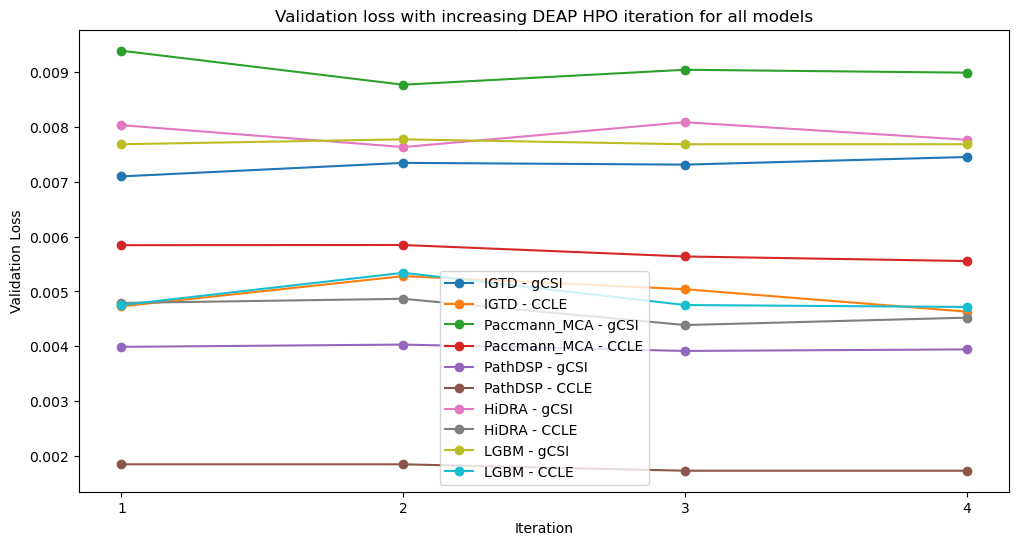

In [155]:
plt.figure(figsize=(12, 6))
all_data = []
# models = ["GraphDRP", "IGTD", "Paccmann_MCA", "PathDSP", "HiDRA", "LGBM"]
models = [ "IGTD", "Paccmann_MCA", "PathDSP", "HiDRA", "LGBM"]

studies = ["gCSI", "CCLE"]
size = "medium"
all_data = []

for model in models:
  for study in studies:
    sorted_iterations, smallest_values, label = process_model_data(base_dir, model, study, size)
    all_data.append((sorted_iterations, smallest_values, label))  # Store data in tuples

# Plot the data after processing everything
for sorted_iterations, smallest_values, label in all_data:
  plt.plot(sorted_iterations, smallest_values, marker='o', label=label)


# Set x-ticks to integer values
plt.xticks(np.arange(min(sorted_iterations), max(sorted_iterations) + 1, 1))


plt.xlabel('Iteration')
plt.ylabel('Validation Loss')
plt.title('Validation loss with increasing DEAP HPO iteration for all models')
plt.legend()
plt.show()

--- Processing model: GraphDRP, study: gCSI ---
{'best': ['./GraphDRP/gCSI/MEDIUM/best-1.json'], 'log': ['./GraphDRP/gCSI/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/gCSI/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/gCSI/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/gCSI/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/gCSI/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/gCSI/MEDIUM/hpo.csv']}
model: ['001', '0000', '512', '0.021638577804816848', 'val_loss', '0.1154632419347763', '38']
model: ['001', '0001', '32', '0.03533235561246276', 'val_loss', '0.1154632419347763', '81']
model: ['001', '0002', '16', '0.054105244020367184', 'val_loss', '0.5533385276794434', '110']
model: ['001', '0003', '32', '0.00015145175483629418', 'val_loss', '0.009395802393555641', '182']
model: ['001', '0004', '32', '0.06981651588852394', 'val_loss', '0.1154632419347763', '78']
model: ['001', '0005', '64', '0.042399297488675346', 'val_loss', '0.1154632419347763', '57']
model: ['001', '0006'

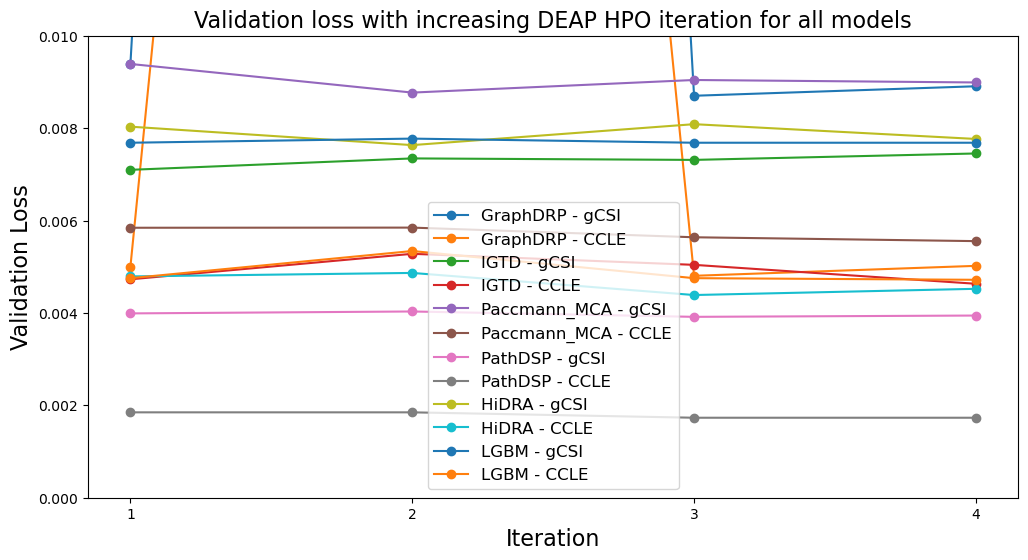

In [183]:
import matplotlib.pyplot as plt
import numpy as np  # Assuming you might use numpy for calculations

plt.figure(figsize=(12, 6))
all_data = []
models = ["GraphDRP", "IGTD", "Paccmann_MCA", "PathDSP", "HiDRA", "LGBM"]

studies = ["gCSI", "CCLE"]
size = "medium"
all_data = []

for model in models:
  for study in studies:
    sorted_iterations, smallest_values, label = process_model_data(base_dir, model, study, size)
    all_data.append((sorted_iterations, smallest_values, label))  # Store data in tuples

# Plot the data after processing everything
for sorted_iterations, smallest_values, label in all_data:
  plt.plot(sorted_iterations, smallest_values, marker='o', label=label)


# Set x-ticks to integer values
plt.xticks(np.arange(min(sorted_iterations), max(sorted_iterations) + 1, 1))

# Clip y-axis at 0.01
plt.ylim(bottom=0.0, top=0.01)  # Set bottom limit to 0.01, keep top limit flexible

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Validation Loss', fontsize=16)
plt.title('Validation loss with increasing DEAP HPO iteration for all models', fontsize=16)
plt.legend( fontsize=12)
plt.show()
